# Sensitivity code tutorial

This notebook is intended to demonstrate how the python-based sensitivity code works, and how one can run it. It is not intended to be used for a full calculation -- full calculations should be written up into a script and run in many parallel jobs on a cluster. Instead, this document is intended to walk you through a calculation start-to-finish, and show you what each step is doing. If there is something that is not explained well, or could be better documented, feel free to get in touch: blenardo@stanford.edu.

You should be able to download this tutorial and, after installing the python dependencies, click all the way through without any errors. If for some reason this doesn't work, please let me know!

## Definitions/glossary

There are a few words that have very specific meanings in the context of the sensitivity code.  We define them here:
* **Component:** A "component" is a specific material/isotope pair. For instance, "Field Ring U238" is a single component. Each component has an associated specific activity, mass, and PDF.
* **PDF:** This stands for "probability density function," and in our context means the distribution in energy/standoff/whatever-space for events from a certain component. PDFs are generated using the processed (clustered & reconstructed) output from the Geant4 simulations.
* **Material:** A "material" is exactly what it sounds like: copper, silicon, Al, etc. 
* **Isotope:** The parent isotope which produces the background PDF. For example, any backgrounds from the Th232 decay chain for a given material will be lumped together, and the events will all be contained in a PDF with the isotope Th232.
* **Group:** A "group" is defined as a grouping of multiple components, with a single PDF corresponding to the weighted sum of each of the component PDFs. Generally, we'd like to form groups of components with similarly-shaped distributions, to avoid degeneracies in our fits. 
* **Livetime:** Our assumption for how long the experiment will run
* **Specific Activity:** How many decays of a given isotope we will get per unit mass of the material. These values come from assay measurements.
* **Mass:** Mass of the component in kg. Used in conjunction with Specific Activity to determine the weight (meaning number of counts) of the PDF for each component. 
* **Weight:** Here, the word "weight" does not refer to a physical property, but rather a coefficient that scales the PDF to the appropriate number of counts that we expect to see in our experiment.
* **Hit Efficiency:** This isn't actually used in the sensitivity code, but is stored in the Materials Spreadsheet nonetheless; it quantifies what fraction of decays from a given component create an event in a specific energy region (e.g. the FWHM ROI) and mass (e.g. the inner two tons)



## Import relevant libraries

I'll assume you're already in the ```sensitivity/work``` directory, since that's where this notebook is located. If you're not, you may have to adjust the paths of some things below.

First, of course, we need to import the relevant libraries. The sensitivity code has several dependencies that you will need to install:
* xlrd
* uproot
* pandas
* histlite

You should be able to install all of them with ```pip```. Note that if you're working on a cluster at LLNL or wherever, you should create a virtual environment using ```virtualenv``` so you can add software locally. The instructions to do this on LLNL computers can be found here: https://hpc.llnl.gov/software/development-environment-software/python#python-virtualenv. If you need further help installing the packages, please get in touch (blenardo@stanford.edu). Beyond this point, I'll assume that you've installed all of these already.

The nEXO-specific python classes are contained in the directory: 
<code>sensitivity/modules</code>
To correctly import them, you'll need to append this directory to python's search path, as below.


In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../modules')

/g/g20/lenardo1/nEXO/sensitivity/work


Alternatively, you could prepend this directory to your python path, like so:
> ```export PYTHONPATH=/your/path/to/sensitivity/modules:$PYTHONPATH```

In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (7,6)

In [3]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

# Step 1: Creating a workspace

The ```workspace``` class is a container that stores and organizes all of the various sub-objects and data tables that are required for the sensitivity calculation. These include:

* **df_components**, which is a pandas-dataframe version of the Materials Spreadsheet from the Materials Database. This contains details for every component in the detector, including specific activities and masses, as well as the Geant4-generated distributions, which we need to generate an overall event distribution.
* **df_group_pdfs**, which is a pandas dataframe containing the PDFs for each group that we'll use in the fit.
* **neg_log_likelihood**, which is the object that contains the likelihood function and a list of the free parameters in the fit.
* **minimizer**, which is the minimizer (we currently use iMinuit)
* **livetime**, a variable storing the number of seconds that we expect the experiment to run
* **histogram_axis_names**, which is a list storing the names of each dimension in the fit (e.g. "energy", "standoff", etc.)
* **config**, a dict which contains configuration parameters, read in from a YAML configuration file. Most importantly, the YAML file contains the group assignments, i.e. which group each component will be added to to generated the summed PDFs. The YAML file can also contain things like custom user-defined weights for the PDFs, if you want to play around with activities and stuff.

The ```workspace``` also has methods to populate the sub-objects.

Below, we create a workspace, then load in the input dataframe and grouped PDFs from files generated by the materials database. 


In [4]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace( config = 'config/TUTORIAL_config.yaml')

**Note:** This is where groups are defined. If you want to change the groupings, etc, you should create a new configuration YAML file and add it here.




# Step 2: Generating or loading the components table

The "components table" is the same as "df_components" described above - it should combine the information from the Materials Database (activities, hit efficiencies, etc.) with the Geant4-generated distributions into one easily-manipulated table. 

The components table can be included in three different ways:
* Generating a new ComponentsTable file by directly reading the Materials DB
* Generating a new ComponentsTable file using an Excel spreadsheet downloaded from the Materials DB
* Loading a previously-generated ComponentsTable file

**All** of these options require that you have the Geant4-generated distributions available as histlite objects, stored in a file. In this tutorial, the file containing all the histograms is the file ```tutorial/Histograms_Baseline2017Take2.h5```

> **Note:** As of Jan 22, 2020, the Geant4-produced histograms are all stored in ROOT files. There is a script in the directory ```sensitivity/work/conversion_scripts``` called ```ConvertRootPDFsToHistlite.py``` which can do this conversion for you.

In [5]:
histograms_dataframe = pd.read_hdf('../tutorial/Histograms_Baseline2017Take2.h5')
histograms_dataframe.head()

,Filename,Histogram,HistogramAxisNames
0,MC-073_Sens_K40_CalibrationGuideTube1.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
1,MC-073_Sens_Co60_CalibrationGuideTube1.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
2,MC-073_Sens_Th232_CalibrationGuideTube1.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
3,MC-073_Sens_U238_CalibrationGuideTube1.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
4,MC-074_Sens_Co60_CalibrationGuideTube2.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"


You can see how this file is laid out - there are three columns: the name of the original Geant4 file (from which we can see which component is represented in the distribution), the actual histogram itself (a histlite object), and the names of each of the axes.

## a) Generating a new ComponentsTable directly from the Materials DB (recommended)

We can download data directly from the MaterialsDB using the `nEXOMaterialsDBInterface` class. You don't need to use it directly; the `nEXOFitWorkspace` class has a `nEXOMaterialsDBInterface` object inside of it a method that creates the components table without needing to access the DBInterface object directly.

You'll need to specify which "Tagged Geometry" you want the data from. This is a specific detector model (e.g. "Baseline 2017 - Take 2") and is labeled with an ID number that the code refers to as a "geometry tag". If you are not sure what the correct tag is for your geometry, you can print out a list of the available options, as shown below:

In [37]:
workspace.ConnectToMaterialsDB()
workspace.materialsDB.PrintAllGeometryTags()

D-004: 2017 Baseline
D-009: 2017Take2 - squat10
D-010: 2017Take2 - tall10
D-014: 2017Take2 - squat20
D-015: 2017Take2 - squat05
D-016: 2017Take2 - tall20
D-017: 2017Take2 - tall05
D-005: 2017 Baseline - Take 2
D-001: Detector (ver. 15a)
D-018: 2017Take2 - 3tonnes
D-019: 2017Take2 - 66tonnes
D-020: 2017Take2 - 4tonnes
D-021: 2017Take2 - 6tonnes
D-023: 2019 baseline
D-003: Caio's Detector
D-002: HFE and Cryostats Summary
D-006: Test sheet for solder
D-008: 2017Take2 - newFRoffset


We see that the geometry tag for "2017 Baseline - Take 2" is `D-005`. We'll proceed with that one.

To create a ComponentsTable, you can simply run the following function:

In [39]:
workspace.CreateComponentsTableFromMaterialsDB('D-005',\
                        histograms_file='../tutorial/Histograms_Baseline2017Take2.h5')


Retrieved data for geometry D-005: 2017 Baseline - Take 2

Outer Cryostat Support (Resin)
    - Material: Carbon Composite (Resin)
    - Mass/Area: 345 kg x 1 units
    - Isotopes and activities:
          * U-238 (Ra-226):      -0.0229 +/- 0.0581     mBq/kg     (Symmetric error (68% C.L.))
          * Th-232 (Ra-228):     -0.0537 +/- 0.0468     mBq/kg     (Symmetric error (68% C.L.))
          * K-40:                 -0.311 +/- 0.581      mBq/kg     (Symmetric error (68% C.L.))
          * Co-60:               -0.0375 +/- 0.0168     mBq/kg     (Symmetric error (68% C.L.))
          * Cs-137:               0.0371 +/- 0.0346     mBq/kg     (Symmetric error (68% C.L.))


          Isotope: Cs137	 MC ID: MC-089


Outer Cryostat Support (Fiber)
    - Material: Carbon Composite (Fiber)
    - Mass/Area: 345 kg x 1 units
    - Isotopes and activities:
          * U-238 (Ra-226):        0.501 +/- 0.191      mBq/kg     (Symmetric error (68% C.L.))
          * Th-232 (Ra-228):       0.300 +/- 0

          * Co-60:                -0.594 +/- 0.276      mBq/kg     (Symmetric error (68% C.L.))
          * Cs-137:                0.389 +/- 0.558      mBq/kg     (Symmetric error (68% C.L.))


          Isotope: Cs137	 MC ID: MC-094


HV Feedthrough
    - Material: Copper
    - Mass/Area: 0.275 kg x 1 units
    - Isotopes and activities:
          * U-238:                 0.254 +/- 0.008      ppt        (Symmetric error (68% C.L.))
          * Th-232:                0.127 +/- 0.057      ppt        (Symmetric error (68% C.L.))
          * K-40:                 0.0939 +/- 0.0642     mBq/kg     (Symmetric error (68% C.L.))
          * Co-60:               0.00022 +/- 0.00187    mBq/kg     (Symmetric error (68% C.L.))
          * Cs-137:              0.00353 +/- 0.00403    mBq/kg     (Symmetric error (68% C.L.))


          Isotope: Cs137	 MC ID: MC-079


HV Feedthrough Core
    - Material: Teflon
    - Mass/Area: 0.364 kg x 1 units
    - Isotopes and activities:
          * K-40:        

          * K-40:                    548 +/- 33.9       pg/g       (Symmetric error (68% C.L.))

SiPMs
    - Material: SiPM
    - Mass/Area: 63.07392e-6 kg x 46080 units
    - Isotopes and activities:
          * U-238:                 0.857 +/- 0.046      ppt        (Symmetric error (68% C.L.))
          * Th-232:                0.449 +/- 0.118      ppt        (Symmetric error (68% C.L.))

SiPM Cables
    - Material: Kapton
    - Mass/Area: 10000 cm^2 x 1 units
    - Isotopes and activities:
          * Th-232:                  2.3 +/-            pg/cm²     (limit)
          * U-238:                   4.7 +/- 0.7        pg/cm²     (obs)

SiPM Electronics
    - Material: Silicon
    - Mass/Area: 2.196 kg x 1 units
    - Isotopes and activities:
          * U-238:                  13.2 +/- 0.1        ppt        (Symmetric error (68% C.L.))
          * Th-232:                 25.7 +/- 0.7        ppt        (Symmetric error (68% C.L.))

Charge Tiles Backing
    - Material: Quartz
    - Ma

/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/pandas/core/generic.py:2378: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['PDFName', 'Component', 'Isotope', 'MC ID', 'Activity ID', 'SpecActivErrorType', 'Histogram', 'HistogramAxisNames', 'Group']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## b) Generating a new ComponentsTable from an Excel spreadsheet

This is now the "old way" of doing things, but it is also possible to generate the components table from an Excel spreadsheet, which can be downloaded from the Materials Database. For now, we will use the one located at ```tutorial/Summary_D-005_v25_2020-01-21.xls```

> **Note**: if you download a new spreadsheet from the Materials DB, it won't work right out of the box. You have to open it in Excel and "Save As" a .xls file (old-school Excel), then use the .xls file with the sensitivity code. This is an inconveniet bug, but I haven't yet figured out how to fix it.

In [6]:
excelFile = '../tutorial/Summary_D-005_v25_2020-01-21.xls'
histogramsFile = '../tutorial/Histograms_Baseline2017Take2.h5'

workspace.CreateComponentsTableFromXLS( excelFile, histogramsFile )

Loading sheets...
	Reading SpecificActivities...
	Reading DetectorSpecifications...
	Reading SS_ExpectedCounts
	Reading MS_ExpectedCounts
	Reading MC_RawCounts_SS_Integrals
	Reading MC_RawCounts_MS_Integrals
Sheets loaded.


../modules/nEXOExcelTableReader.py:129: RuntimeWarning: invalid value encountered in sqrt
  thispdf['Expected Counts Err'] = np.sqrt( thispdf['Expected Counts'] ) #thisrowSS['Error'].iloc[0] + thisrowMS['Error'].iloc[0]



Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']


Writing table to file ComponentsTable_D-005_v25_2020-01-21.h5

Elapsed time = 11.7 seconds (0.195 minutes).


/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/pandas/core/generic.py:2378: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['PDFName', 'Component', 'Isotope', 'MC ID', 'Histogram', 'HistogramAxisNames', 'Activity ID', 'TotalHitEff_N', 'Group']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


> **Note:** There are two warnings generated. The first is generated when we try to compute the uncertainty on the number of expected counts from a component with a negative activity. The second is an issue with storing the dataframe in HDF5 files. Neither prevents the calculation from running, so we'll ignore them for now.

Reading the output above, you can get an idea of what goes into the components table. The components table is now stored in ```workspace.df_components```, as shown below:

In [7]:
workspace.df_components.head()

,PDFName,Component,Isotope,MC ID,Histogram,HistogramAxisNames,Total Mass or Area,Halflife,SpecActiv,SpecActivErr,RawActiv,RawActivErr,Activity ID,Expected Counts,Expected Counts Err,Expected Counts UL,TotalHitEff_N,TotalHitEff_K,Group
0,U238_OuterCryostatSupportResin,Outer Cryostat Support (Resin),U-238,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,4.468000e+09,-0.0229,0.0581,-0.007900,0.020044,R-016.3.4.1,-0.380705,NaN,1.584225,1000000000,1527.000000,Far
1,Th232_OuterCryostatSupportResin,Outer Cryostat Support (Resin),Th-232,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,1.400000e+10,-0.0537,0.0468,-0.018526,0.016146,R-016.3.4.1,-2.638408,NaN,3.772107,1000000000,4512.880171,Far
2,K40_OuterCryostatSupportResin,Outer Cryostat Support (Resin),K-40,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,1.248000e+09,-0.3110,0.5810,-0.107295,0.200445,R-016.3.4.1,-0.375835,NaN,1.154449,1000000000,111.000000,Far
3,Co60_OuterCryostatSupportResin,Outer Cryostat Support (Resin),Co-60,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,5.270000e+00,-0.0375,0.0168,-0.012937,0.005796,R-016.3.4.1,-0.300308,NaN,0.222038,1000000000,785.000000,Far
4,U238_OuterCryostatSupportFiber,Outer Cryostat Support (Fiber),U-238,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,4.468000e+09,0.5010,0.1910,0.172845,0.065895,R-017.3.3.1,8.328956,2.885993,13.513572,1000000000,1527.000000,Far


## c) Reading the components table from an existing file


We can also just read in the components table, if we've already generated it in a previous run. To illustrate this, we'll load in the file that was created when we ran the ```CreateComponentsTableFromXLS``` method in part **a)**. 

In the above example, this file was named ```ComponentsTable_D-005_v25_2020-01-21.h5```. It can be loaded using the ```LoadCompontentsTableFromFile``` method:

In [8]:
workspace.LoadComponentsTableFromFile( 'ComponentsTable_D-005_v25_2020-01-21.h5' )


Loading input data froma previously-generated components table....


Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']


# Step 3: Generate grouped PDFs

The fit that we're eventually going to do requires us to be able to fit a distribution to several PDFs (probability density function), leaving the amplitude of those PDFs free to float in the fit. If we did this with the Geant4-generated distributions from each individual component, we would have way too many free parameters and degenerate distributions, and the fits would never converge. To fix this, we group the distributions into PDFs which represent some aggregate background source. For example, we group the U238 contributions from anything inside the TPC (e.g. the field rings, cathode, etc.) into a single PDF, called "Internals_U238". The Th232 contributions produce a different-enough spectrum that we can fit them separately; they are contained in the "Internals_Th232" group.

> **Note:** Groups are assigned to each component in the configuration file that you loaded in when you constructed the ```workspace``` object.
> **Note:** Components can be omitted from the fit by assigning them to the "Off" group.

Grouping is accomplished using the ```CreateGroupedPDFs()``` method, and the grouped PDFs are stored in ```workspace.df_group_pdfs```, as shown below:




In [9]:
workspace.CreateGroupedPDFs()

workspace.df_group_pdfs.head()



Creating grouped PDFs....
	Group:     	Expected Counts:
	Far        	        4882.22
	Vessel_U238 	       19053.03
	Vessel_Th232 	        2169.26
	Internals_U238 	       46351.84
	Internals_Th232 	        8667.26
	FullTPC_Co60 	         216.19
	FullTPC_K40 	    32572615.75
	Rn222      	        9107.27
	FullLXeBb2n 	    27949377.02
	FullLXeBb0n 	           0.00
	Xe137      	          46.52
	Total Sum  	    60612486.34


,Group,Histogram,TotalExpectedCounts
0,Far,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",4882.22
1,Vessel_U238,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",19053
2,Vessel_Th232,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",2169.26
3,Internals_U238,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",46351.8
4,Internals_Th232,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",8667.26


The grouped PDFs should be normalized to 1. We can check this explicitly:

In [10]:
# Check and make sure any component is normalized to one total count.
h_intu238 = workspace.df_group_pdfs['Histogram'].loc[ \
                      workspace.df_group_pdfs['Group']=='Internals_U238' ].values[0]
print(h_intu238)

Hist(2 bins in [0,2], 280 bins in [700.0,3500.0], 25 bins in [0.0,650.0], with sum 0.9999999999999999, 7709 empty bins, and 0 non-finite values)


We see that this histogram is indeed normalized to 1, and we can also see the binning information.

# Step 4: Create a model object, use it to generate fake data.

The ```nEXOFitModel``` class is a way of organizing all of the various grouped PDFs and the free parameters (e.g. the number of events in each PDF) and combining them into a single distribution which can be plotted, sampled, and fit to data.

We first create the model object, then fill it using the DataFrame containing the grouped PDFs.

In [11]:
model = nEXOFitModel.nEXOFitModel()
model.AddPDFsFromDataframe( workspace.df_group_pdfs )


Once we've added the PDFs, we can sum them together (weighting them appropriately) to create a full model of the data. This is done with the ```GenerateModelDistribution()``` method. We can also sample it using the ```GenerateDataset()```, which just Poisson-samples each weighted bin.

In [12]:
initial_model = model.GenerateModelDistribution()
fake_data = model.GenerateDataset()

Let's take a look at our model compared to the fake dataset that we just created. To do so, we'll project all the events onto the energy axis:

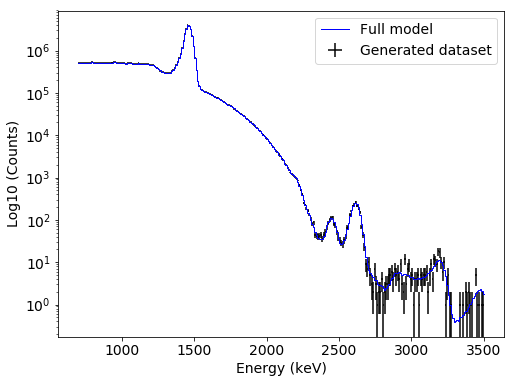

In [13]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots (1, 1, figsize=(8, 6))

# Here we're projecting the distributions onto the energy axis, so we see a mix of single-
# and multi-site events
hl.plot1d(ax, initial_model.project([1]), color=(0.,0.,1.), linewidth=1, label='Full model')
hl.plot1d(ax, fake_data.project([1]), color=(0.,0.,0.), crosses=True, label='Generated dataset')

plt.xlabel('Energy (keV)')
plt.ylabel('Log10 (Counts)')
plt.yscale('log')
plt.legend()

# Step 5: Create likelihood object

The ```nEXOFitLikelihood``` contains a model object like the one created above, and allows us to compute a Poisson-based likelihood by comparing this model to a given dataset. We'll minimize the value of this likelihood in the next step.

In [14]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()

In [15]:
# Load PDFs into the model contained in the likelihood object. This also
# executes the GenerateModelDistribution() method under the hood.

likelihood.AddPDFDataframeToModel( workspace.df_group_pdfs )
likelihood.PrintVariableList()


Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 4.882e+03    False     None       69.87         False          (None,None)
Num_Vessel_U238         1.905e+04    False     None       138.0         False          (None,None)
Num_Vessel_Th232        2.169e+03    False     None       46.58         False          (None,None)
Num_Internals_U238      4.635e+04    False     None       215.3         False          (None,None)
Num_Internals_Th232     8.667e+03    False     None       93.1          False          (None,None)
Num_FullTPC_Co60        216.2        False     None       14.7          False          (None,None)
Num_FullTPC_K40         3.257e+07    False     None       5.707e+03     False          (None,None)
Num_Rn222               9.107e+03    False     None       95.43         False          (None,None)
Num_FullLXeBb2n         2.795e+07    False     None       5.287e+03     False          (None,None)
Num_Full

Next, we can add a dataset with which we can compare this model. Since in the sensitivity calculation, the datasets are generated by sampling the model itself, this looks somewhat circular:


In [16]:
likelihood.AddDataset( likelihood.model.GenerateDataset())

In [17]:
# Next, set limits so that none of the PDFs go negative in the fit.

for var in likelihood.model.variable_list:
    likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = 0., \
                                  upper_limit = var['Value']*10.)
    
    
likelihood.PrintVariableList()

Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 4.882e+03    False     None       69.87         False          (0.0 ,48822.15158717998)
Num_Vessel_U238         1.905e+04    False     None       138.0         False          (0.0 ,190530.2605959463)
Num_Vessel_Th232        2.169e+03    False     None       46.58         False          (0.0 ,21692.59708083749)
Num_Internals_U238      4.635e+04    False     None       215.3         False          (0.0 ,463518.4165649111)
Num_Internals_Th232     8.667e+03    False     None       93.1          False          (0.0 ,86672.56708537013)
Num_FullTPC_Co60        216.2        False     None       14.7          False          (0.0 ,2161.8837805932717)
Num_FullTPC_K40         3.257e+07    False     None       5.707e+03     False          (0.0 ,325726157.48000866)
Num_Rn222               9.107e+03    False     None       95.43         False          (0.0 ,91072.67168202484)
N

Finally, to make sure it all looks the way we expect it to, let's use the model contained in ```likelihood.model_obj``` to recreate Figure 4 from the 2016 nEXO sensitivity paper.

Plotting Far
Plotting VesselU238
Plotting VesselTh232
Plotting InternalsU238
Plotting InternalsTh232
Plotting FullTPCCo60
Plotting FullTPCK40
Plotting Rn222
Plotting FullLXeBb2n
Plotting FullLXeBb0n
Plotting Xe137


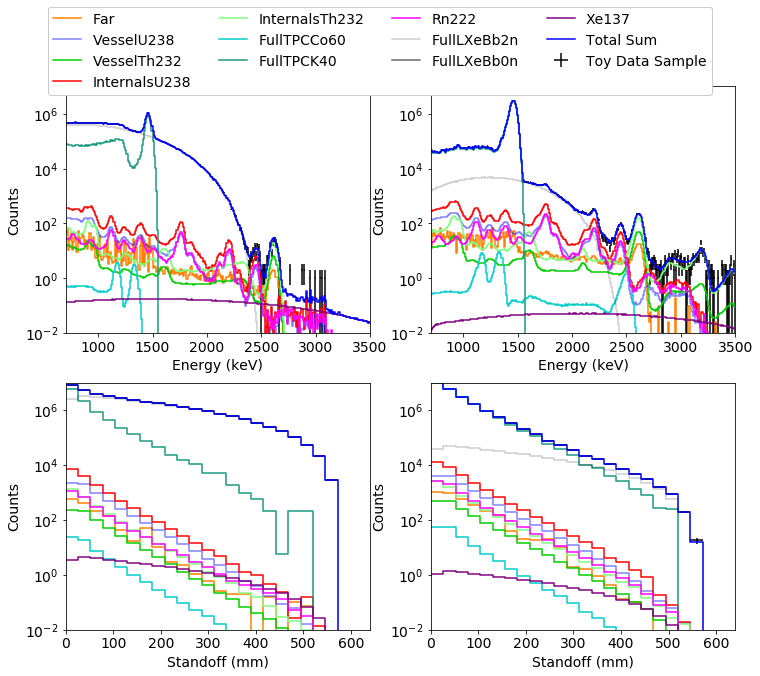

In [18]:
likelihood.PlotModelDistributions(output_filename='tutorial_input_model_distributions.png',save=True,show=True,plot_data=True)



On the left is the single-site (SS) distribution, and on the right is the multi-site (MS) distribution. 

Just for fun, we can also access variables by index in the ```variable_list```. This will become useful later in the fitting routine.

In [19]:

bb0n_index = likelihood.GetVariableIndex( 'Num_FullLXeBb0n' )

print('Which variable is Num_FullLXeBb0n? {}'.format(bb0n_index))

print(likelihood.model.variable_list[bb0n_index]['Name'])


Which variable is Num_FullLXeBb0n? 9
Num_FullLXeBb0n


# Step 6: Running a single fit

To fit, I use the ```iminuit``` package (see https://iminuit.readthedocs.io/en/latest/ for more information). This is the same minimizer that RooFit uses, so we should get consistent results. Below we'll walk through a fit using ```iminuit```. 

**Note:** the fitting is now wrapped in a method of the ```nEXOFitLikelihood``` class, so you shouldn't need to do this in a real application.

In [20]:
from iminuit import Minuit

In [21]:
# Regenerate a new dataset, a re-assign the initial values from the Materials Spreadsheet.
likelihood.AddPDFDataframeToModel( workspace.df_group_pdfs )
likelihood.AddDataset( likelihood.model.GenerateDataset() )

# Here I illustrate how one can implement gaussian constraints on a variable.
# The constraint is implemented by adding (value-constraint)**2/(sqrt(2)*width**2)
# to the likelihood function
rn222_idx = likelihood.GetVariableIndex('Rn222')
likelihood.SetGaussianConstraintFractional(likelihood.model.variable_list[rn222_idx]['Name'],\
                                           likelihood.model.variable_list[rn222_idx]['Value'],\
                                           0.1)



# Next, set limits so that none of the PDFs go negative in the fit.
for var in likelihood.model.variable_list:
    if 'Bb0n' in var['Name']:
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = 0., \
                                  upper_limit = 80.)
    else: 
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = 0., \
                                  upper_limit = var['Value']*10.)

# Finally, fix the Co60 parameter, since this PDF is really underconstrained.
likelihood.SetVariableFixStatus('Num_FullTPC_Co60',True)

likelihood.PrintVariableList() 
    
print('\n\nConstraints:')
for constraint in likelihood.model.constraints:
    print(constraint)
print('\n')

# Also, I store the initial values in a new array outside
# of the likelihood object, so it's easy to pass to Minuit

initial_values = np.ones(len(likelihood.model.variable_list))



Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 4.882e+03    False     None       69.87         False          (0.0 ,48822.15158717998)
Num_Vessel_U238         1.905e+04    False     None       138.0         False          (0.0 ,190530.2605959463)
Num_Vessel_Th232        2.169e+03    False     None       46.58         False          (0.0 ,21692.59708083749)
Num_Internals_U238      4.635e+04    False     None       215.3         False          (0.0 ,463518.4165649111)
Num_Internals_Th232     8.667e+03    False     None       93.1          False          (0.0 ,86672.56708537013)
Num_FullTPC_Co60        216.2        True      None       14.7          False          (0.0 ,2161.8837805932717)
Num_FullTPC_K40         3.257e+07    False     None       5.707e+03     False          (0.0 ,325726157.48000866)
Num_Rn222               9.107e+03    False     None       95.43         True           (0.0 ,91072.67168202484)
N

The parameters for Minuit are passes as tuples, so we need to create tuples of the variable names, the step size for each parameter, and a boolean array which indicates which variables will float in the minimization.

In [22]:
# Increase the step size for the Bb0n variable
likelihood.SetFractionalMinuitInputError('Num_FullLXeBb0n', 0.01/0.0001)


# par_fix_tuple is a tuple of bools. If a value is true, then the variable
# at that index will be fixed in the minimization. Here we fix the number of 
# Co60 events, since we can see from above that they have essentially no
# impact on the overall distribution (they will be buried by the 2nuBB))

m = Minuit.from_array_func( likelihood.ComputeNegLogLikelihood, \
                            np.copy(initial_values), \
                            error = likelihood.GetMinuitInputErrorTuple(), \
                            fix   = likelihood.GetVariableFixTuple(), \
                            name  = likelihood.GetVariableNamesTuple(), \
                            limit = likelihood.GetVariableLimitsTuple(), \
                            errordef = 0.5 )
m.get_param_states()

---------------------------------------------------------------------------------------------------------
|   | Name                |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------------------
| 0 | Num_Far             |    1.0    |   69.9    |            |            |    0    | 48822.2 |       |
| 1 | Num_Vessel_U238     |    1.0    |   138.0   |            |            |    0    | 190530  |       |
| 2 | Num_Vessel_Th232    |    1.0    |   46.6    |            |            |    0    | 21692.6 |       |
| 3 | Num_Internals_U238  |    1.0    |   215.3   |            |            |    0    | 463518  |       |
| 4 | Num_Internals_Th232 |    1.0    |   93.1    |            |            |    0    | 86672.6 |       |
| 5 | Num_FullTPC_Co60    |    1.0    |   14.7    |            |            |    0    | 2161.88 |  yes  |
| 6 | Num_FullTPC_K40     |  0.000E4  |  0.571E4  |            |            |    0    |3.25726e+08|       |
| 7 | Num_Rn222           |    1.0    |   95.4    |            |            |    0    | 91072.7 |       |
| 8 | Num_FullLXeBb2n     |  0.000E4  |  0.529E4  |            |            |    0    |2.79494e+08|       |
| 9 | Num_FullLXeBb0n     |   1.000   |   0.010   |            |            |    0    |   80    |       |
| 10| Num_Xe137           |    1.0    |    6.8    |            |            |    0    | 465.167 |       |
---------------------------------------------------------------------------------------------------------

Above you see a table of the fit parameters in the Minuit object. We expect these to change once we actually run the fit. The minimizer is run using the ```migrad()``` method:

In [23]:
m.migrad()


------------------------------------------------------------------
| FCN = 6.144                   |    Ncalls=1441 (1441 total)    |
| EDM = 7.66E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
|   | Name                |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------------------
| 0 | Num_Far             |  0.76E4   |  0.11E4   |            |            |    0    | 48822.2 |       |
| 1 | Num_Vessel_U238     |    28     |     3     |            |            |    0    | 190530  |       |
| 2 | Num_Vessel_Th232    |   1220    |    170    |            |            |    0    | 21692.6 |       |
| 3 | Num_Internals_U238  |  0.612E5  |  0.017E5  |            |            |    0    | 463518  |       |
| 4 | Num_Internals_Th232 |  0.893E4  |  0.030E4  |            |            |    0    | 86672.6 |       |
| 5 | Num_FullTPC_Co60    |    1.0    |   14.7    |            |            |    0    | 2161.88 |  yes  |
| 6 | Num_FullTPC_K40     |  0.326E8  |  0.000E8  |            |            |    0    |3.25726e+08|       |
| 7 | Num_Rn222           |  0.90E4   |  0.07E4   |            |            |    0    | 91072.7 |       |
| 8 | Num_FullLXeBb2n     |  2.795E7  |  0.001E7  |            |            |    0    |2.79494e+08|       |
| 9 | Num_FullLXeBb0n     |   0.000   |   1.764   |            |            |    0    |   80    |       |
| 10| Num_Xe137           |    36     |    19     |            |            |    0    | 465.167 |       |
---------------------------------------------------------------------------------------------------------

Below are a couple of examples of how to access the useful numbers produced by the ```migrad``` minimization.

In [24]:
nll_best = m.fval

par_values_best = np.array([value for key,value in m.values.items()])

print('Best fit NLL value: {:4.4}'.format(nll_best))

print('\nFree parameters and their best fit values:')
for key, value in m.values.items():
    print('{:<25} {:4.4}'.format(key,value))

Best fit NLL value: 6.144

Free parameters and their best fit values:
Num_Far                   7.608e+03
Num_Vessel_U238           28.44
Num_Vessel_Th232          1.219e+03
Num_Internals_U238        6.124e+04
Num_Internals_Th232       8.932e+03
Num_FullTPC_Co60           1.0
Num_FullTPC_K40           3.258e+07
Num_Rn222                 9.039e+03
Num_FullLXeBb2n           2.795e+07
Num_FullLXeBb0n           1.098e-08
Num_Xe137                 35.54


# Step 7: Compute the sensitivity of nEXO

Computing the sensitivity requires one to generate many toy datasets with no signal events. Each dataset is then fit using the following procedure:
1. Fit the model to the dataset with all parameters floating to get the global best-fit log-likelihood, $\mathcal{L}_{best}$
2. Fix the number of signal events in the fit to 0, then re-fit the (constrained) model to the dataset to get the log-likelihood of the 0-signal hypothesis ($\mathcal{L}(N_{signal} = 0$)
3. Compute the test statistic $\lambda$ as two times the log of the ratio of the likelihoods (or two times the difference of the log-likelihoods):
\begin{equation}
\lambda = 2 \times [\,\,\mathcal{L}(N_{signal}=0) - \mathcal{L}_{best} \,\,]
\end{equation}
4. Repeat steps 2 and 3 for increasing values of $N_{signal}$, fitting to the same dataset, until the likelihood ratio $\lambda$ crosses the threshold for a 90% confidence level. Assuming Wilks' theorem, this threshold is 2.706. Record the value of $N_{signal}$ for which the likelihood crosses this threshold.
5. Generate new toy datasets and repeat this procedure, assembling an ensemble of 90% confidence limits. 





We can then compute the expected 90% CL sensitivity of the experiment using the formula: 
\begin{equation}
T_{1/2} = \frac{ \epsilon \,\, N_{atoms} \,\, t_{live} }{N_{signal}} \times \text{ln}(2)
\end{equation}
where $\epsilon$ is the $0\nu\beta\beta$ detection efficiency, $N_{atoms}$ is the number of $^{136}$Xe atoms inside the fiducial volume, $t_{live}$ is the experiment's livetime, and $N_{signal}$ is taken as the median value of the ensemble generated by the procedure above. This gives us an expectation of the 90% CL that nEXO will set on the halflife of $0\nu\beta\beta$-decay


In [25]:
# I'll re-load all the input data here to ensure we're starting fresh, and also to
# illustrate how one would do this in a standalone script

workspace.LoadComponentsTableFromFile( 'ComponentsTable_D-005_v25_2020-01-21.h5' )
workspace.CreateGroupedPDFs()

likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel( workspace.df_group_pdfs )
initial_guess = likelihood.GetVariableValues()


# Next, set limits so that none of the PDFs go negative in the fit.
for var in likelihood.model.variable_list:
    if 'Bb0n' in var['Name']:
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = 0., \
                                  upper_limit = 80.)
    else: 
        likelihood.SetVariableLimits( var['Name'], \
                                  lower_limit = 0., \
                                  upper_limit = var['Value']*10.)
        
        
# Fluctuate and set Rn222 constraint
rn222_idx = likelihood.GetVariableIndex('Rn222')
rn222_constraint_val = (np.random.randn()*0.1 + 1)*initial_guess[rn222_idx]
likelihood.SetGaussianConstraintAbsolute(likelihood.model.variable_list[rn222_idx]['Name'],\
                                                         rn222_constraint_val, \
                                                         0.1 * initial_guess[rn222_idx])


# Fix the Co60 parameter, since this PDF is really underconstrained.
likelihood.SetVariableFixStatus('Num_FullTPC_Co60',True)

# Increase the step size for the Bb0n variable
likelihood.SetFractionalMinuitInputError('Num_FullLXeBb0n', 0.01/0.0001)

print('\n\n')
likelihood.PrintVariableList() 

print('\nConstraints:')
for constraint in likelihood.model.constraints:
    print('\t{}'.format(constraint))
print('\n')



Loading input data froma previously-generated components table....


Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']

Creating grouped PDFs....

	Group:     	Expected Counts:
	Far        	        4882.22
	Vessel_U238 	       19053.03
	Vessel_Th232 	        2169.26
	Internals_U238 	       46351.84
	Internals_Th232 	        8667.26
	FullTPC_Co60 	         216.19
	FullTPC_K40 	    32572615.75
	Rn222      	        9107.27
	FullLXeBb2n 	    27949377.02
	FullLXeBb0n 	           0.00
	Xe137      	          46.52
	Total Sum  	    60612486.34



Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_F

## An example sensitivity calculation

In this example, we'll generate an ensemble of 10 datasets. This is not nearly enough to actually compute the sensitivity, but it's illustrative. 

We begin by defining some variables which will control the fitting loops and store the fit results:

In [30]:
num_datasets = 20    # How many datasets to generate for our ensemble
num_hypotheses = 10    # How many different values of N_signal to try
xvals = np.linspace(0,28,num_hypotheses)    # Array of values to be used as N_signal hypotheses
lambdas = np.zeros((num_datasets,num_hypotheses))   # Empty array which will contain the computed test statistics
best_fit_converged = np.ones(num_datasets,dtype=bool)    # Array for flagging failed fits
converged_mask = np.ones((num_datasets,num_hypotheses),dtype=bool)

global_initial_values = np.copy(initial_guess)

Then, we execute a loop 10 times, where each time we generate a new toy dataset from the initial distribution (which, remember is defined by the activities for each PDF calculated from the Materials DB). For each dataset, we fit it with our model once to get the best-fit likelihood. We then execute a sub-loop which fixes the number of signal events at different values (each representing a different "hypothesis"), and store the results of our fit in the arrays defined above.

> **Note:** Below we fix the value of the Co60 PDF; leaving it floating leads to a higher non-convergence rate. This is because the rate is so small that it's basically unconstrained in the fit (which also means it has no real impact on our results). 

In [31]:
import time
start = time.time() # Just for benchmarking

# Set the verbosity. Heads up - this prints out a LOT of stuff
VERBOSE = False

for j in range(0,num_datasets):
    
    print('Running dataset {} at {:3.3} min\n'.format(j,(time.time()-start)/60.))
    
    initial_values = np.copy(global_initial_values)
    
    # Create a new dataset, using the inital input parameters (no signal.)
    likelihood.model.UpdateVariables( initial_values )
    likelihood.model.GenerateModelDistribution()
    likelihood.AddDataset( likelihood.model.GenerateDataset() )
    
    # Fix the Co60 paramter, since it's underconstrained and can lead to failures
    # the fit convergence.
    likelihood.SetAllVariablesFloating()
    likelihood.SetVariableFixStatus('Num_FullTPC_Co60',True)
    
    # Fluctuate and set the Rn222 constraint, (the fluctuation avoids a bias in the
    # pull distributions)
    rn222_idx = likelihood.GetVariableIndex('Rn222')
    rn222_constraint_val = (np.random.randn()*0.1 + 1)*initial_guess[rn222_idx]
    likelihood.SetGaussianConstraintAbsolute(likelihood.model.variable_list[rn222_idx]['Name'],\
                                                         rn222_constraint_val, \
                                                         0.1 * initial_guess[rn222_idx])

    if VERBOSE:
        likelihood.PrintVariableList()
        print('\nConstraints:')
        for constraint in likelihood.constraints:
            print('\t{}'.format(constraint))
        print('\n')

        
    
    for i in (range(0,num_hypotheses)):
        
        print('Running hypothesis {} ({:3.3} signal counts)'.format(i,xvals[i]))
        
        signal_idx = likelihood.GetVariableIndex( 'Num_FullLXeBb0n' ) # Get the index of the 0nu variable
        
        initial_values = np.copy(global_initial_values)
        initial_values[signal_idx] = xvals[i]

        # Here, we fix the number of signal events to a specific hypothesis.
        likelihood.SetVariableFixStatus('Bb0n',True)
        
        lambda_fit_result = likelihood.ComputeLambdaForPositiveSignal(\
                                                    initial_values=initial_values,\
                                                    signal_name='Bb0n',\
                                                    signal_expectation=xvals[i],\
                                                    fixed_fit_signal_value=xvals[i],\
                                                    print_level=0 )
        
        lambdas[j,i]   = lambda_fit_result['lambda']
        num_iterations = lambda_fit_result['fixed_fit_iterations']
        converged_mask[j][i] = lambda_fit_result['fixed_fit_covar'] # if the fixed fit had a good covariance matrix
        
        if VERBOSE:
            print('\tLambda = {:3.3}'.format(lambdas[j,i]))
            print('\tNumber of iterations: {}'.format(int(num_iterations)))
            print('\tIs valid? {}'.format(likelihood.fitter.get_fmin()['is_valid']))
            print('\tAccurate covariance? {}'.format(likelihood.fitter.get_fmin()['has_accurate_covar']))
            print('\tForced pos def covariance? {}'.format(likelihood.fitter.get_fmin()['has_made_posdef_covar']))
            #likelihood.PrintVariableList()
            print('\n')
                
            
    print('\t{} fits converged ({:4.4}%)\n\n'.format( np.sum(converged_mask[j]), \
                                100.*np.sum(converged_mask[j])/len(converged_mask[j])) )
            
print('\nElapsed: {:4.4}s'.format(time.time()-start))

Running dataset 0 at 7.47e-06 min

Running hypothesis 0 (0.0 signal counts)

Running best fit...

Best fit result NLL: -5.172


Fit with Num_FullLXeBb0n fixed at 0.0 cts...

Running hypothesis 1 (3.11 signal counts)


Fit with Num_FullLXeBb0n fixed at 3.11 cts...

Running hypothesis 2 (6.22 signal counts)


Fit with Num_FullLXeBb0n fixed at 6.22 cts...

Running hypothesis 3 (9.33 signal counts)


Fit with Num_FullLXeBb0n fixed at 9.33 cts...

Running hypothesis 4 (12.4 signal counts)


Fit with Num_FullLXeBb0n fixed at 12.4 cts...

Running hypothesis 5 (15.6 signal counts)


Fit with Num_FullLXeBb0n fixed at 15.6 cts...

Running hypothesis 6 (18.7 signal counts)


Fit with Num_FullLXeBb0n fixed at 18.7 cts...

Running hypothesis 7 (21.8 signal counts)


Fit with Num_FullLXeBb0n fixed at 21.8 cts...

Running hypothesis 8 (24.9 signal counts)


Fit with Num_FullLXeBb0n fixed at 24.9 cts...

Running hypothesis 9 (28.0 signal counts)


Fit with Num_FullLXeBb0n fixed at 28.0 cts...

	10 fit

Best fit result NLL: -6.654


Fit with Num_FullLXeBb0n fixed at 0.0 cts...

Running hypothesis 1 (3.11 signal counts)


Fit with Num_FullLXeBb0n fixed at 3.11 cts...

Running hypothesis 2 (6.22 signal counts)


Fit with Num_FullLXeBb0n fixed at 6.22 cts...

Running hypothesis 3 (9.33 signal counts)


Fit with Num_FullLXeBb0n fixed at 9.33 cts...

Running hypothesis 4 (12.4 signal counts)


Fit with Num_FullLXeBb0n fixed at 12.4 cts...

Running hypothesis 5 (15.6 signal counts)


Fit with Num_FullLXeBb0n fixed at 15.6 cts...

Running hypothesis 6 (18.7 signal counts)


Fit with Num_FullLXeBb0n fixed at 18.7 cts...

Running hypothesis 7 (21.8 signal counts)


Fit with Num_FullLXeBb0n fixed at 21.8 cts...

Running hypothesis 8 (24.9 signal counts)


Fit with Num_FullLXeBb0n fixed at 24.9 cts...

Running hypothesis 9 (28.0 signal counts)


Fit with Num_FullLXeBb0n fixed at 28.0 cts...

	10 fits converged (100.0%)


Running dataset 9 at 1.22 min

Running hypothesis 0 (0.0 signal counts)

Ru

Running hypothesis 1 (3.11 signal counts)


Fit with Num_FullLXeBb0n fixed at 3.11 cts...

Running hypothesis 2 (6.22 signal counts)


Fit with Num_FullLXeBb0n fixed at 6.22 cts...

Running hypothesis 3 (9.33 signal counts)


Fit with Num_FullLXeBb0n fixed at 9.33 cts...

Running hypothesis 4 (12.4 signal counts)


Fit with Num_FullLXeBb0n fixed at 12.4 cts...

Running hypothesis 5 (15.6 signal counts)


Fit with Num_FullLXeBb0n fixed at 15.6 cts...

Running hypothesis 6 (18.7 signal counts)


Fit with Num_FullLXeBb0n fixed at 18.7 cts...

Running hypothesis 7 (21.8 signal counts)


Fit with Num_FullLXeBb0n fixed at 21.8 cts...

Running hypothesis 8 (24.9 signal counts)


Fit with Num_FullLXeBb0n fixed at 24.9 cts...

Running hypothesis 9 (28.0 signal counts)


Fit with Num_FullLXeBb0n fixed at 28.0 cts...

	10 fits converged (100.0%)


Running dataset 17 at 2.6 min

Running hypothesis 0 (0.0 signal counts)

Running best fit...

Best fit result NLL: -4.286


Fit with Num_FullLXeBb0n fi

Once the fit routine has completed, we have arrays of the $\lambda$ test statistic for each dataset. These arrays represent the value of the test statistic as a function of the assumed number of signal events. We expect that most of the time they should be minimized near 0, and get larger as the assumed num_signal increases. Let's check that by plotting the curves below:

Number in which the best-fit converged: 20


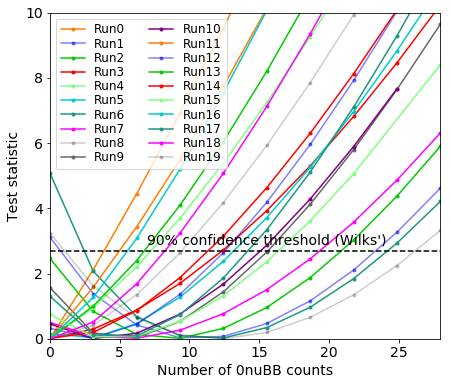

In [32]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (7,6)

for i in range(0,num_datasets):
    
    # Note: I only plot points for which the fit converged. 
    if best_fit_converged[i]:
        plt.plot(xvals[converged_mask[i]],lambdas[i][converged_mask[i]],'-o',label='Run{}'.format(i),markersize=3)
    
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')
plt.text(7.,2.9,'90% confidence threshold (Wilks\')',fontsize=14)
plt.axis([0.,28.,0.,10.])
plt.legend(loc='upper left',fontsize=12,ncol=2,labelspacing=0.1)
plt.ylabel('Test statistic')
plt.xlabel('Number of 0nuBB counts')
print('Number in which the best-fit converged: {}'.format(np.sum(best_fit_converged)))

We can calculate where each curve crosses the 90% CL threshold by fitting it to some function and estimating the root of that function. Here we use a quadratic fit. An example for a single curve is shown here:

Text(0.5, 0, 'Assumed number of 0nuBB counts')

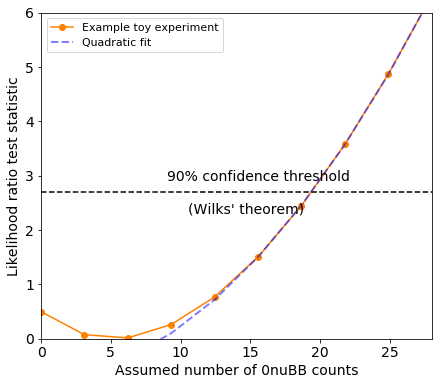

In [33]:
curve_idx = 7 # Choose one of the curves, it doesn't matter which one

plt.plot(xvals,lambdas[curve_idx],'-o',label='Example toy experiment')
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')

# Define a mask around the crossing point, and use only fits which converged:
indexes = range(len(lambdas[curve_idx]))
mask = (lambdas[curve_idx]>1.)&\
        (lambdas[curve_idx]<7.)&\
        (converged_mask[curve_idx])&\
        (indexes>np.argmin(lambdas[curve_idx]))

if len(xvals[mask]) > 0:
    # Fit a quadratic function, then plot it on top of the test statistic curve
    p = np.polyfit(xvals[mask],lambdas[curve_idx][mask],2.)
    plt.plot(xvals, p[0]*xvals**2 + p[1]*xvals + p[2],'--',linewidth=2,label='Quadratic fit')

plt.text(9.,2.9,'90% confidence threshold',fontsize=14)
plt.text(10.5,2.3,'(Wilks\' theorem)',fontsize=14)
plt.axis([0.,28.,0.,6.])
plt.legend(loc='upper left',fontsize=11)
plt.ylabel('Likelihood ratio test statistic')
plt.xlabel('Assumed number of 0nuBB counts')

Then we do it for all 10 of the fits. The "-1" means that any toy experiment for which the fits failed will have a negative crossing value, and be easy to remove from the ensemble later.

In [34]:
crossings = np.zeros(num_datasets) - 1.

for i in range(0,num_datasets):
    
        # only fit around the threhsold...
        mask = (lambdas[i]>1.)&(lambdas[i]<7.)&converged_mask[i]
        
        if len(xvals[mask]) > 0:
            p = np.polyfit(xvals[mask],lambdas[i][mask],2.)
            crossings[i] = (-p[1] + np.sqrt( p[1]**2 - 4*(p[0])*(p[2]-2.706) ))/(2*p[0])
        
print(crossings)


[ 3.91626579 23.70016087 21.05657857 12.37373523  7.3118985  13.22569952
 24.70005092 19.40281338  9.47340788 15.85906043 15.14685817  5.04546191
 12.57434088  6.81919584 11.40789834 16.45041902  5.62536001 14.38647606
  8.32553311 26.27058617]


Finally, we can study the distribution of crossing points to estimate the 90% CL of nEXO. We don't have nearly enough toy experiments to compute a median with any precision, but from here you get the idea. For productions runs, make any necessary changes to the above procedure, then run it >1000 times, and you have a sensitivity!

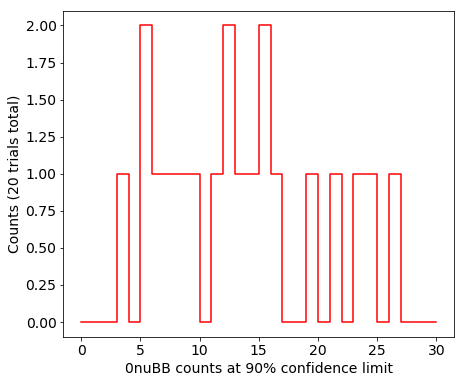

In [35]:
fig,ax = plt.subplots(1,1)
hteststats = hl.hist(crossings[crossings>0.],bins=np.linspace(0,30,31))
hl.plot1d(ax,hteststats,color='r')
ax.set_ylabel('Counts ({} trials total)'.format(num_datasets))
ax.set_xlabel('0nuBB counts at 90% confidence limit')
plt.savefig('example_sensitivity_distribution.png',dpi=400,bbox_inches='tight')

Text(0.5, 0, '0nuBB counts at 90% confidence limit')

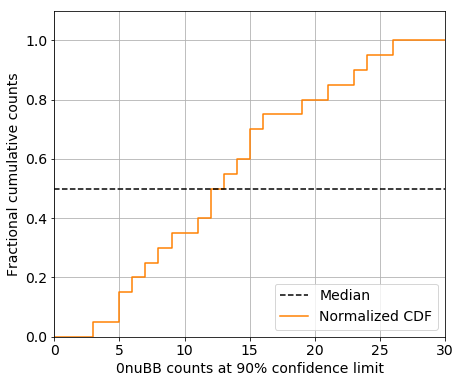

In [36]:
plt.figure(1)
hcdf = hl.Hist(hteststats.bins,np.cumsum(hteststats.values)/np.sum(hteststats.values))
hl.plot1d(hcdf,label='Normalized CDF')
plt.plot(np.linspace(0.,30.,10),np.ones(10)*0.5,'--k',label='Median')

plt.axis([0.,30.,0.,1.1])
plt.grid()
plt.legend(loc='lower right')

plt.ylabel('Fractional cumulative counts')
plt.xlabel('0nuBB counts at 90% confidence limit')
